# Final Project
### Môn học: CSC17104 - Lập trình cho Khoa học dữ liệu
****

**Nhóm 26**
<table style='float:left;'>
    <tr>
        <th style='text-align:center;'>MSSV</th>
        <th style='text-align:center;'>Họ và Tên</th>
        <th style='text-align:center;'>Mức độ hoàn thành(%)</th>
    </tr>
    <tr>
        <td style='text-align:center;'>21120178</td>
        <td style='text-align:left;'>Văn Bá Bảo Huy</td>
        <td style='text-align:center;'>100%</td>
    </tr>
    <tr>
        <td style='text-align:center;'>21120071</td>
        <td style='text-align:left;'>Nguyễn Thị Thanh Hoa</td>
        <td style='text-align:center;'>100%</td>
    </tr>
    <tr>
        <td style='text-align:center;'>21120174</td>
        <td style='text-align:left;'>Nguyễn Thị Gái</td>
        <td style='text-align:center;'>100%</td>
    </tr>
</table>

### Environment check & Import nescessary packages

In [1]:
import sys
sys.executable
!pip install -q kaggle

In [18]:
import os
import numpy as np
import pandas as pd
import json
import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from skimage import io

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", message="Matplotlib is currently using module://matplotlib_inline.backend_inline")

# **Phase 1**: Collecting Data

**Dataset**: Full TMDB Movies Dataset 2023 (930K Movies)<br>
**Kaggle**: https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/data

In [20]:
#Download data from Kaggle with api-key
notebook_dir = os.path.dirname(os.path.realpath("__file__"))
os.chdir(notebook_dir)
!mkdir kaggle
!touch kaggle/kaggle.json
api_json = {"username":"tyzenr","key":"08b25d2b177116a2cb7dfddc38ab964b"}
with open('kaggle/kaggle.json', 'w') as file:
    json.dump(api_json, file)
!chmod 600 kaggle/kaggle.json

with open('kaggle/kaggle.json', 'r') as file:
    api_json = json.load(file)

os.environ['KAGGLE_USERNAME'] = api_json['username']
os.environ['KAGGLE_KEY'] = api_json['key']

import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('asaniczka/tmdb-movies-dataset-2023-930k-movies', path='.', unzip=True)

**1. Dữ liệu về chủ đề gì? Nguồn dữ liệu?**<br>
- Chủ đề dữ liệu: Bộ dữ liệu của hơn 930.000 bộ phim trong tập dữ liệu TMDB.<br>
- Nguồn dữ liệu: Kaggle
<br>

**2. Kiểm tra vấn đề bản quyền của tập dữ liệu.**<br>
- `CC0: Public Domain` - No Right Reserved
- CC0 cho phép các nhà khoa học, nhà giáo dục, nghệ sĩ, những người sáng tạo và chủ sở hữu khác của nội dung được bảo vệ bản quyền hoặc cơ sở dữ liệu *từ bỏ* những lợi ích đó đối với tác phẩm của họ và do đó đặt chúng hoàn toàn nhất có thể trong phạm vi công cộng, để những người khác có thể tự do xây dựng, nâng cao và tái sử dụng tác phẩm cho bất kỳ mục đích nào mà không bị hạn chế theo luật bản quyền hoặc cơ sở dữ liệu.
<br>

**3. Tác giả của tập dữ liệu đã thu thập bằng cách nào?** <br>
- Dữ liệu được thu thập từ TMDB Open API.
<br>

# **Phase 2**: Exploring Data

### 2.0 Đọc dữ liệu

In [3]:
df = pd.read_csv("TMDB_movie_dataset_v11.csv")
df.head(3)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"


### 2.1 Có bao nhiêu hàng và bao nhiêu cột?

In [4]:
row, col = df.shape[0], df.shape[1]
print('Dữ liệu có', row, 'hàng và', col, 'cột.')

Dữ liệu có 969743 hàng và 23 cột.


###  2.2 Ý nghĩa của mỗi hàng là gì?

### 2.3 Có 'hàng trùng lặp' không?

### 2.4 Ý nghĩa của từng cột là gì?

### 2.5 Kiểu dữ liệu hiện tại của mỗi cột là gì? Có cột nào có kiểu dữ liệu không phù hợp không?

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973454 entries, 0 to 973453
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    973454 non-null  int64  
 1   title                 973443 non-null  object 
 2   vote_average          973454 non-null  float64
 3   vote_count            973454 non-null  int64  
 4   status                973454 non-null  object 
 5   release_date          872831 non-null  object 
 6   revenue               973454 non-null  int64  
 7   runtime               973454 non-null  int64  
 8   adult                 973454 non-null  bool   
 9   backdrop_path         280779 non-null  object 
 10  budget                973454 non-null  int64  
 11  homepage              105876 non-null  object 
 12  imdb_id               564032 non-null  object 
 13  original_language     973454 non-null  object 
 14  original_title        973443 non-null  object 
 15  

In [5]:
def dtype(o):
    
    dtypes = set(o.apply(type))
    
    return dtypes

for col in df.columns:
    print("Kiểu dữ liệu của column: %10s: %s" % (col, dtype(df[col])))

Kiểu dữ liệu của column:         id: {<class 'int'>}
Kiểu dữ liệu của column:      title: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column: vote_average: {<class 'float'>}
Kiểu dữ liệu của column: vote_count: {<class 'int'>}
Kiểu dữ liệu của column:     status: {<class 'str'>}
Kiểu dữ liệu của column: release_date: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:    revenue: {<class 'int'>}
Kiểu dữ liệu của column:    runtime: {<class 'int'>}
Kiểu dữ liệu của column:      adult: {<class 'bool'>}
Kiểu dữ liệu của column: backdrop_path: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:     budget: {<class 'int'>}
Kiểu dữ liệu của column:   homepage: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:    imdb_id: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column: original_language: {<class 'str'>}
Kiểu dữ liệu của column: original_title: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu của column:   overview: {<class 'str'>, <class 'float'>}
Kiểu dữ liệu

**Nhận xét:**  
- Cột `release_date` đang có dtype là str và float. Để đúng về ý nghĩa, ta sẽ thực hiện bước tiền xử lý là chuyển sang dạng `datetime`.
- Hầu hết các cột có giá trị `float` là vì các cột có giá trị `nan`

### 2.6 Với mỗi cột số, các giá trị được phân bố như thế nào?
- Phần trăm giá trị còn thiếu là bao nhiêu?
- Tối thiểu? tối đa? Chúng có bất thường không?

Các cột số có trong dữ liệu là: `id`, `popularity`, `budget`, `revenue`, `runtime`, `vote_average`, `vote_count`.
Để kiểm tra các giá trị phân bố, ta tạo một DataFrame `nume_col_df` có chứa các cột thuộc kiểu numeric và được thống kê với các số liệu về:

`missing_ratio`: Tỉ lệ các giá trị thiếu trong cột.

`min`: Giá trị nhỏ nhất trong cột.

`max`: Giá trị lớn nhất trong cột.

In [7]:
numeric_df = df.select_dtypes(include=['number'])
nume_col_df = pd.DataFrame( index=["missing_ratio", "min", "max"], columns=numeric_df.columns)

nume_col_df.loc["missing_ratio"] = (numeric_df.isna().sum() / numeric_df.size) *100
nume_col_df.loc["min"] = np.min(numeric_df)
nume_col_df.loc["max"] = np.max(numeric_df)

nume_col_df

,id,vote_average,vote_count,revenue,runtime,budget,popularity
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0
max,2923706026.0,2923706026.0,2923706026.0,2923706026.0,2923706026.0,2923706026.0,2923706026.0


Không có giá trị bị thiếu trong các cột số. Các giá trị `min` và `max` không có gì bất thường.

### 2.7 Với mỗi cột phân loại, các giá trị được phân bổ như thế nào?
- Phần trăm giá trị còn thiếu là bao nhiêu?
- Có bao nhiêu giá trị khác nhau? Hiển thị một số giá trị đó.
- Chúng có bất thường không?

# **Phase 3**: Preprocessing & Asking Meaningful questions
Yêu cầu:
- Số lượng câu hỏi đặt ra cần lớn hơn hoặc bằng số lượng thành viên ($\ge 3$)
- Câu hỏi đặt ra cần có ý nghĩa (tác dụng của việc tìm kiếm câu trả lời cho câu hỏi đó) và không được quá dễ 🙂
- Chú ý đến chất lượng của từng câu hỏi, không phải số lượng câu hỏi.
- Trong file Notebook, với mỗi câu hỏi cần thể hiện được:
    - Nội dung câu hỏi
    - Ý nghĩa của câu hỏi

## **3.0** Preprocessing

#### Remove duplicated/meaningless rows and columns

#### Handle missing data & Convert data

In [ ]:
df.info()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969743 entries, 0 to 969742
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    969743 non-null  int64  
 1   title                 969732 non-null  object 
 2   vote_average          969743 non-null  float64
 3   vote_count            969743 non-null  int64  
 4   status                969743 non-null  object 
 5   release_date          871061 non-null  object 
 6   revenue               969743 non-null  int64  
 7   runtime               969743 non-null  int64  
 8   adult                 969743 non-null  bool   
 9   backdrop_path         280394 non-null  object 
 10  budget                969743 non-null  int64  
 11  homepage              105536 non-null  object 
 12  imdb_id               562897 non-null  object 
 13  original_language     969743 non-null  object 
 14  original_title        969732 non-null  object 
 15  

#### Visualize some data
Ở phần này ta sẽ biểu diễn một vài dữ liệu được cung cấp và đưa ra các nhận xét.

## **3.1** Asking meaningful question

<table style='float:left;'>
    <tr>
        <th style='text-align:center;'>STT</th>
        <th style='text-align:center;'>Nội dung</th>
        <th style='text-align:center;'>Trình bày</th>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 1</td>
        <td style='text-align:left;'>Những yếu tố nào là đặc trưng của 1 bộ phim có doanh thu cao?</td>
        <td style='text-align:center;'><a href='#cauhoi_1'>C1</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 2</td>
        <td style='text-align:left;'>Thể loại phim nào được yêu thích nhất qua các năm trong giai đoạn từ 2000-2023?</td>
        <td style='text-align:center;'><a href='#cauhoi_2'>C2</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 3</td>
        <td style='text-align:left;'>Cho biết 10 nước có tổng số phim nhiều nhất ở TMDB qua từng năm là những nước nào?</td>
        <td style='text-align:center;'><a href='#cauhoi_3'>C3</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 4</td>
        <td style='text-align:left;'>5 công ty có doanh thu lớn nhất tập trung sản xuất các thể loại nào?</td>
        <td style='text-align:center;'><a href='#cauhoi_4'>C4</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 5</td>
        <td style='text-align:left;'>Với mỗi phim mà người dùng tìm kiếm hoặc đã xem, ta cần đề xuất thêm các phim nào với nội dung/thể loại/... tương tự cho người dùng?</td>
        <td style='text-align:center;'><a href='#cauhoi_5'>C5</a></td>
    </tr>
</table>

# **Phase 4**: Analyzing data to answer each question

### **Câu hỏi 1**: Những yếu tố nào là đặc trưng của 1 bộ phim có doanh thu cao?  <a name="cauhoi_2"></a>

**Ý nghĩa:** 
- Giúp chúng ta xác định được để có được 1 bộ phim có doanh thu cao thì những yếu tố ảnh hưởng là gì. 
- Điều này cung cấp thông tin quan trọng cho ngành công nghiệp điện ảnh để có thể tối ưu hóa chiến lược sản xuất và quảng cáo, tập trung vào việc tạo ra nội dung thu hút và thuận lợi nhất để thu hút đối tượng khán giả và đạt được doanh thu cao.


**Quy trình:**
- Loại bỏ dữ liệu không có doanh thu (vì 1 số lý do doanh thu không được cập nhật).
- Xác định ngưỡng doanh thu cao
- Phân tích tương quan và trực quan hoá
- Đưa ra nhận xét và kết luận

Trong bộ dữ liệu có rất nhiều bộ phim có doanh thu bằng 0. Để tính toán một cách hiệu quả cho câu hỏi trên đầu tiên ta sẽ tiến hành loại bỏ các cột này.

In [10]:
positive_revenue_df = df.loc[df['revenue'] > 0]
positive_revenue_df['revenue'].describe()

count    1.905500e+04
mean     3.860549e+07
std      1.212376e+08
min      1.000000e+00
25%      8.789650e+04
50%      2.471778e+06
75%      2.100000e+07
max      2.923706e+09
Name: revenue, dtype: float64

74.96720020991866   25.032799790081345


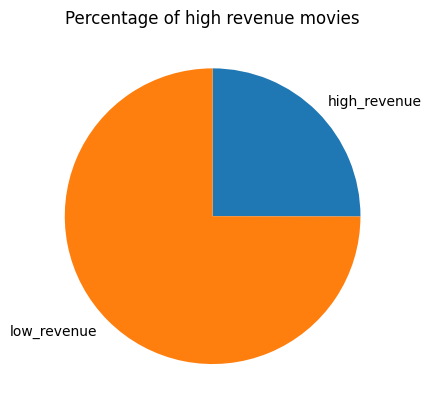

In [11]:
high_revenue = positive_revenue_df['revenue'].quantile(.75)
high_revenue_percent = positive_revenue_df['revenue'][positive_revenue_df['revenue'] >= high_revenue].count() / positive_revenue_df.shape[0] *100

high_revenue_df = positive_revenue_df[positive_revenue_df['revenue'] >= high_revenue]

plt.pie([high_revenue_percent, 100-high_revenue_percent], labels = ['high_revenue', 'low_revenue'], startangle = 90, counterclock = False)
plt.title('Percentage of high revenue movies');
print(100-high_revenue_percent, ' ', high_revenue_percent)

Trước khi phân tích kỹ hơn thì ta sẽ có tổng quan về tỷ lệ phim có doanh thu cao(được tính theo phân vị 75%):
- Tỷ lệ phim có doanh thu cao là 25%
- Tỷ lệ phim doanh thu thấp là 75%

Ta sử dụng **corr()** để tính giá trị tương quan và **searbon** để vẽ biểu đồ mối tương quan giữa các yếu tố khác đến doanh thu trong những bộ phim có doanh thu cao. Trong đó: 
- 1: Tương quan hoàn toàn tích cực.
- 0: Không có tương quan tuyến tính.
- -1: Tương quan hoàn toàn tiêu cực.

Correlation between revenue and vote_average: 0.11
Correlation between revenue and vote_count: 0.67
Correlation between revenue and runtime: 0.13
Correlation between revenue and budget: 0.65
Correlation between revenue and popularity: 0.17


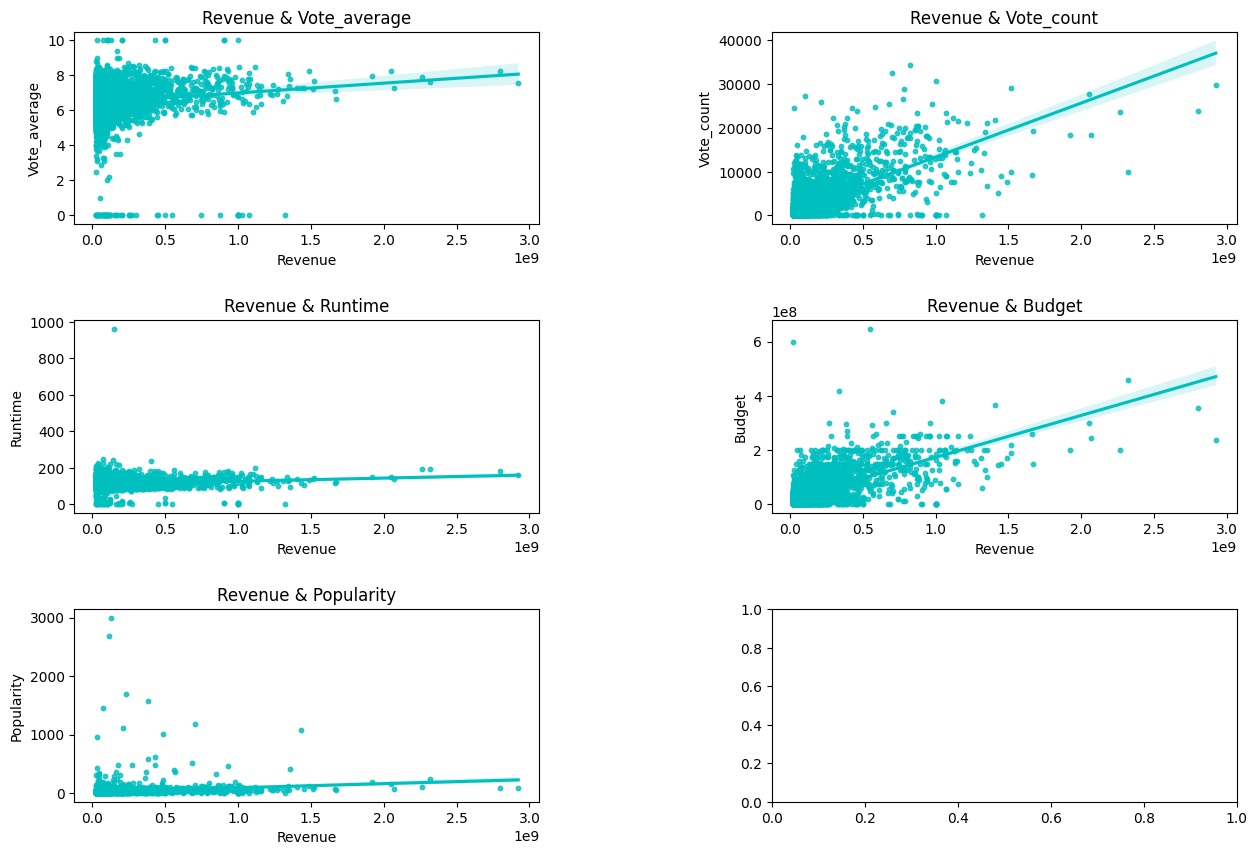

In [12]:
features = high_revenue_df.select_dtypes(include=['number']).columns.tolist()
features.remove('revenue')
features.remove('id')


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.regplot(x=high_revenue_df['revenue'], y=high_revenue_df[feature], color='c', scatter_kws={'s': 10}, ax=axes[i])
    
    axes[i].set_title(f"Revenue & {feature.capitalize()}", fontsize=12)
    axes[i].set_xlabel("Revenue", fontsize=10)
    axes[i].set_ylabel(feature.capitalize(), fontsize=10)

    correlation = high_revenue_df['revenue'].corr(high_revenue_df[feature])
    print(f"Correlation between revenue and {feature}: {correlation:.2f}")

plt.show()

Dựa trên giá trị mối tương quan được tính, ta có thể đưa ra một số nhận xét về mức độ tương quan giữa doanh thu và các thuộc tính số khác như:

- **Điểm đánh giá trung bình (vote_average)**: Mối tương quan là 0.11, cho thấy có một sự tương quan tích cực nhẹ. Tuy nhiên, mối liên kết này không mạnh.

- **Số lượng phiếu bầu (vote_count)**: Có một mối tương quan đáng kể (0.67) giữa số lượng phiếu bầu và doanh thu. Điều này có thể chỉ ra rằng các bộ phim có số lượng phiếu bầu lớn thường có doanh thu cao.

- **Thời lượng (runtime)**: Mối tương quan là 0.13, cho thấy mối liên kết nhẹ giữa thời lượng và doanh thu.

- **Ngân sách (budget)**: Có một mối tương quan đáng kể (0.65) giữa ngân sách và doanh thu. Điều này có ý nghĩa, vì có thể dự đoán rằng các bộ phim với ngân sách lớn hơn thường có khả năng có doanh thu cao hơn.

- **Độ phổ biến (popularity)**: Có một mối tương quan nhẹ (0.17) giữa độ phổ biến và doanh thu.

Đối với rating của các bộ phim tuy không có sự tuyến tính giữa các bộ phim có doanh thu cao và rating nhưng khi so sánh biểu đồ, chúng ta có thể thấy đối với các bộ phim có doanh thu cao thì mức độ phim bị đánh giá thấp ít hơn rất nhiều so với các bộ phim có doanh thu thấp.

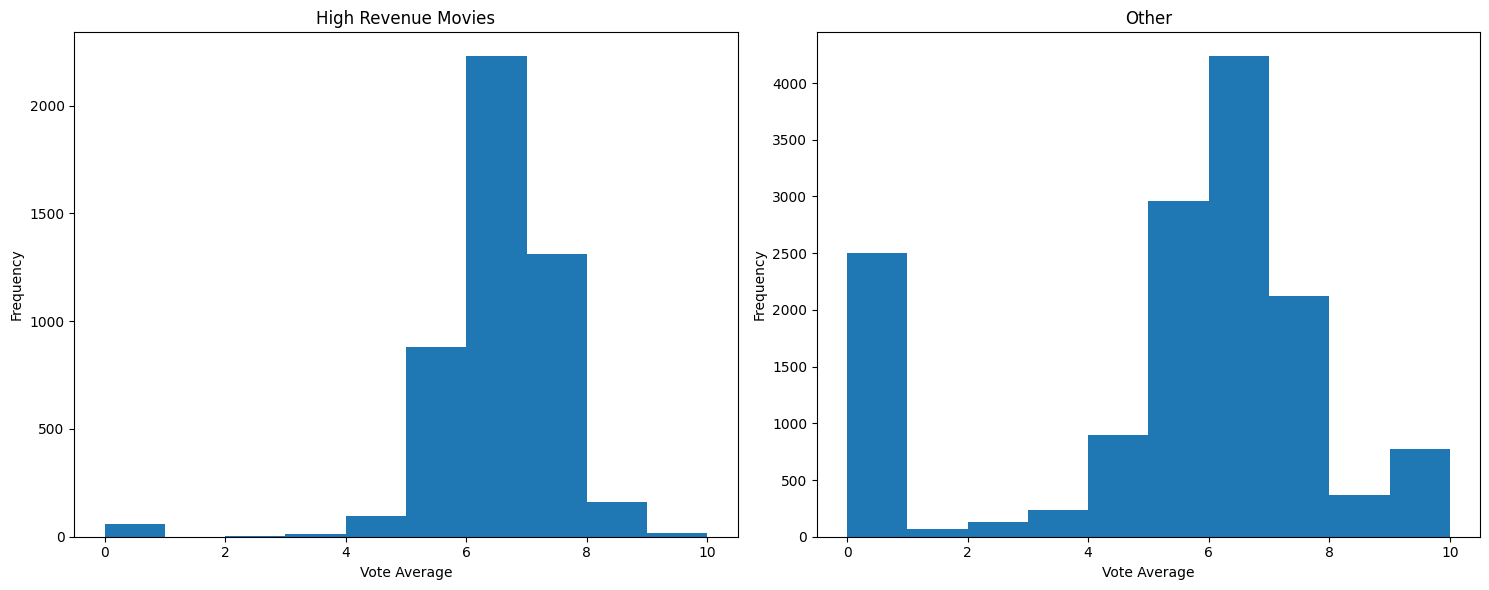

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

other_revenue_df = positive_revenue_df[positive_revenue_df['revenue'] <= high_revenue]

axes[0].hist(high_revenue_df['vote_average'])
axes[0].set_title('High Revenue Movies')
axes[0].set_xlabel('Vote Average')
axes[0].set_ylabel('Frequency')

axes[1].hist(other_revenue_df['vote_average'])
axes[1].set_title('Other')
axes[1].set_xlabel('Vote Average')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### **Câu hỏi 2**: ghi nội dung ở đây<a name="cauhoi_2"></a>

**Ý nghĩa:**

**Thực hiện:**
- Tạo một dataframe mới từ việc phân tách thể loại và chỉ lấy dữ liệu là bộ phim ra mắt trong năm 2000-2023 để có dữ liệu sẵn sàng cho phân tích.
- Nhóm dữ liệu theo năm và thể loại, tính trung bình sự phổ biến của mỗi thể loại trong mỗi năm.
- Vẽ biểu đồ để hiển thị  phân bố sự phổ biến của thể loại qua các năm (2020-2023).

In [8]:
df1 = df.copy()
df1['genres'] = df1['genres'].apply(lambda x: re.split(', |,', str(x)))
df1['genres'] = df1['genres'].apply(lambda x: [] if str(x) == "['nan']" else x)

df1['release_year'] = df1['release_date'].dt.year
df1 = df1[(df1['release_year'] >= 2000) & (df1['release_year'] <= 2023)]

df_genres = df1.assign(genres=df1['genres'])
df_genres = df_genres.explode('genres')
df_year = df_genres.groupby(['release_year', 'genres'])[['popularity']].mean().reset_index()

df_year = df_year.sort_values(by=['release_year', 'popularity'], ascending=False)
df_year

,release_year,genres,popularity
438,2023.0,Adventure,29.740515
437,2023.0,Action,21.378762
451,2023.0,Science Fiction,13.635911
453,2023.0,Thriller,13.400276
449,2023.0,Mystery,10.982259
...,...,...,...
2,2000.0,Animation,2.543059
9,2000.0,History,2.256748
15,2000.0,TV Movie,2.105461
11,2000.0,Music,1.344352


Biểu đồ cho thấy sự phổ biến của các thể loại phim qua các năm từ 2000 đến 2023.


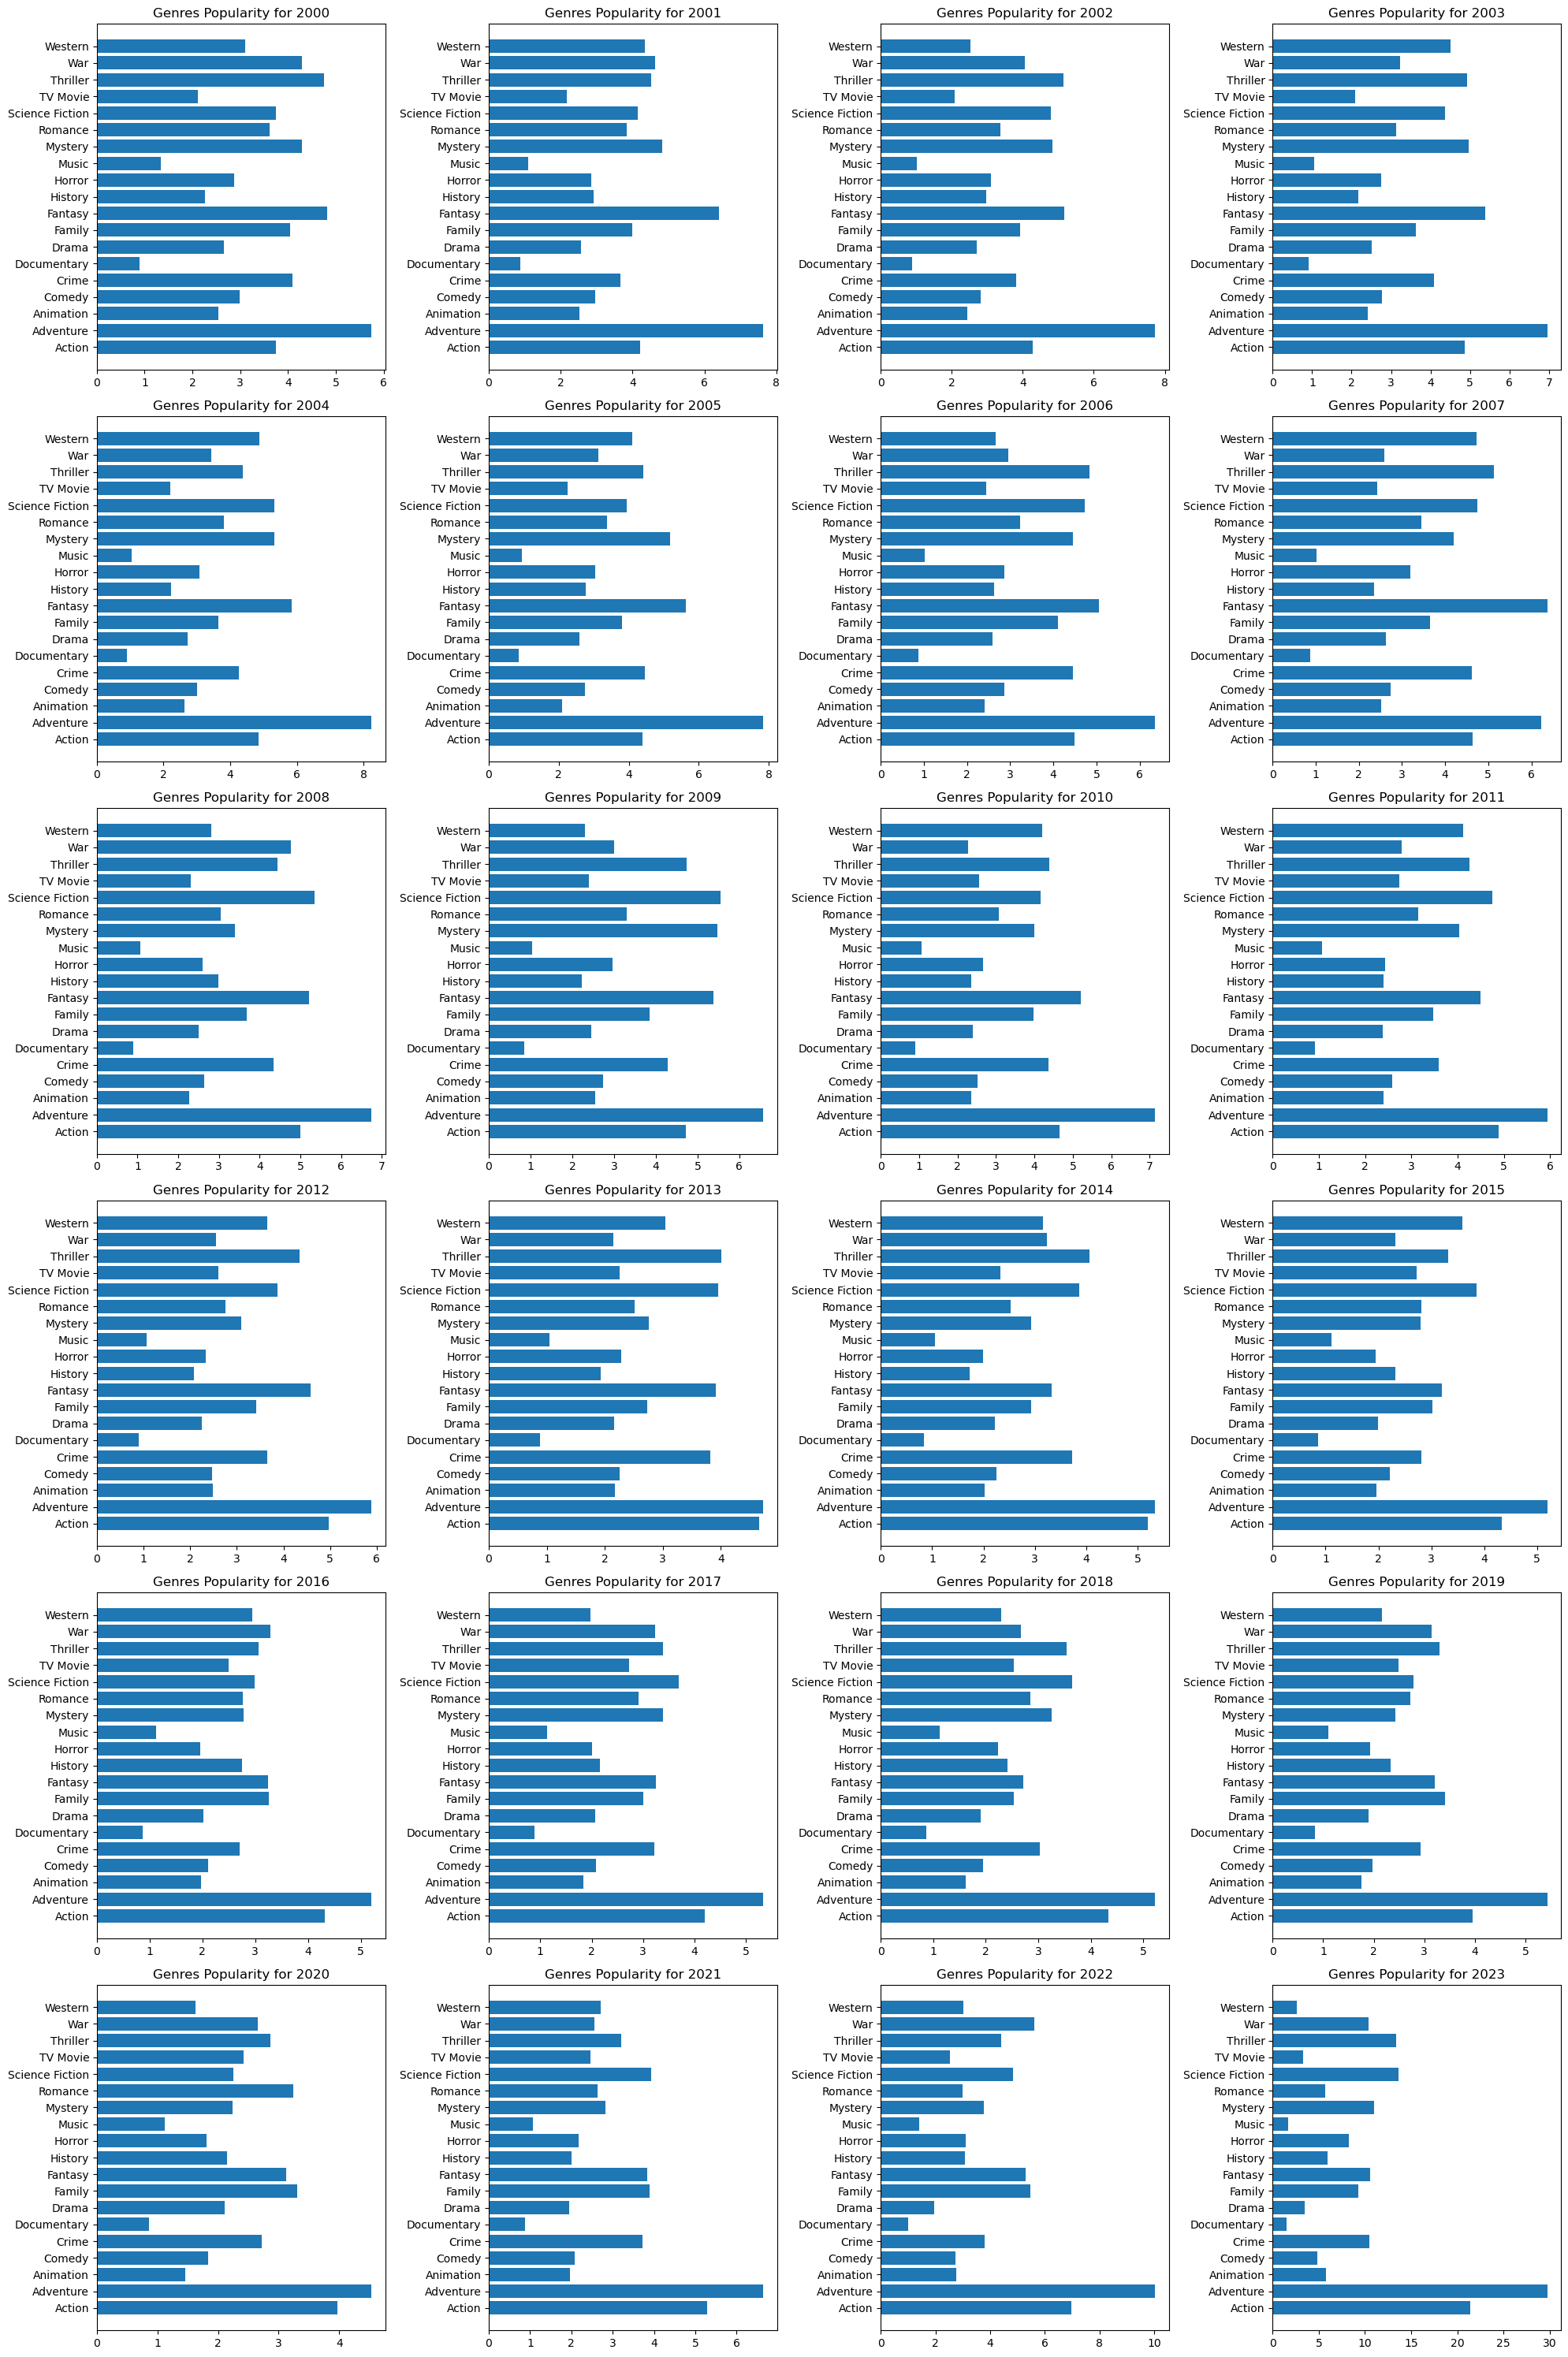

In [9]:
fig, axs = plt.subplots(6, 4, figsize=(20, 30))

for i, ax in enumerate(axs.flatten()):
    year = 2000 + i
    df_current_year = df_year[df_year['release_year'] == year]
    genre_counts = df_current_year.groupby('genres')['popularity'].mean()
    
    ax.barh(genre_counts.index, genre_counts.values)
    ax.set_title(f"Genres Popularity for {year}")

plt.tight_layout()
plt.show()

**Nhận xét:**
- Từ năm 2000-2023, phim thuộc thể loại `Adventure` gần như luôn phổ biến nhất ( chỉ trừ năm 2007 là `Fantasty`).
- Có thể thấy rằng phim thuộc thể loại Adventure luôn được yêu thích nhất trong những năm gần đây. Có lẽ điều đó giải thích tại sao gần đây các nhà sản xuất phim lại thích thể loại Adventure hơn những thể loại khác: chúng có độ phổ biến cao hơn các thể loại khác, hiện tại đang là xu hướng.

Vẽ biểu đổ đường để thấy rõ hơn sự thay đổi độ phổ biến qua mỗi năm.

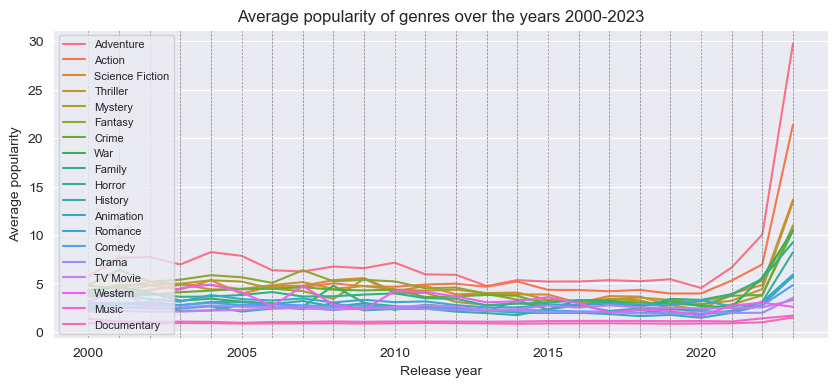

In [10]:
# Filter dataframe to contain only wanted genres:
my_genres_list = df_year['genres'].unique()
my_dataframe = df_year[df_year['genres'].isin(my_genres_list)]

# Create lineplot
plt.figure(figsize=(10, 4))
sns.set_style("darkgrid")
sns.lineplot(data=my_dataframe, x='release_year', y='popularity', hue='genres')

# Add vertical lines for each year
for year in my_dataframe['release_year'].unique():
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5)

plt.title('Average popularity of genres over the years 2000-2023')
plt.xlabel('Release year')
plt.ylabel('Average popularity')

plt.legend(loc='upper left', fontsize=8)
plt.show()

**Nhận xét:**
- Có một sự biến động đáng kể về mức phổ biến của các thể loại phim qua các năm. Điều này có thể phản ánh sự thay đổi trong sở thích và xu hướng của khán giả  trong từng giai đoạn. Một số năm nhất định, như năm 2022-2034, có sự tăng trưởng đặc biệt mạnh mẽ cho một số thể loại như Adventure, Action, và Science Fiction. Các thể loại như Music, Documentary, Western có thể ít phổ biến hơn và có sự biến động lớn.
- Adventure, Action, và Science Fiction thường xuyên nằm trong nhóm các thể loại có mức phổ biến cao nhất.
- Mức phổ biến của các thể loại như Documentary, History, Music, TV Movie thường xuyên ở vị trí thấp.
- Phân bố của mức phổ biến giữa các thể loại thường không đều, với một số thể loại chiếm lĩnh thị trường trong khi các thể loại khác ít phổ biến hơn.

Thay vì mức độ phổ biến trung bình, có thể làm tương tự khi xem xét các thể loại dưới dạng `vote_average` để kiểm tra liệu độ phổ biến cao thì điểm đánh cao hay thấp.

Ta xác định giá trị lớn nhất của cột `vote_average` cho mỗi năm trong khoảng thời gian từ năm 2000 đến 2023 trong  df_genres để tìm thể loại có điểm đánh giá trung bình cao nhất trong khoảng thời gian này.

In [11]:
df_genre_grouped_va = df_genres.groupby(['release_year','genres'])['vote_average'].mean()
df_genre_grouped_va2 = df_genre_grouped_va.to_frame().groupby(level='release_year')['vote_average'].nlargest(1).reset_index(level=0, drop=True).reset_index()
df_genre_grouped_va2 = df_genre_grouped_va2[(df_genre_grouped_va2['release_year'] < 2024) & (df_genre_grouped_va2['release_year'] > 1999)]
df_genre_grouped_va2

,release_year,genres,vote_average
0,2000.0,Adventure,4.635958
1,2001.0,Adventure,4.754836
2,2002.0,Western,5.678480
3,2003.0,Western,5.303333
4,2004.0,Adventure,4.831674
5,2005.0,Adventure,4.915307
6,2006.0,Crime,4.627477
7,2007.0,Adventure,4.709280
8,2008.0,Crime,4.482316
9,2009.0,Mystery,4.627339


**Nhận xét:**
- Thể loại `Adventure` không chỉ phổ biến mà còn đạt điểm đánh giá trung bình cao, chứng tỏ sự ưa chuộng từ cả khán giả và giới phê bình.
- Thể loại phim `TV Movie` được đánh giá cao nhất từ năm 2011 đến 2023 dù mức độ phổ biến trung binh trong những năm này chỉ khá thấp so với các thể loại khác. Có thể xuất phát từ nhiều nguyên nhân như sự hạn chế trong quảng bá,  thiếu sự đa dạng trong nội dung, không kịp thời theo kịp xu hướng hiện đại trong ngành công nghiệp giải trí.  Từ những điều này có thể làm cơ sở cho những quyết định về chiến lược quảng bá và tiếp thị để tăng cường sự nhận biết và phổ biến của thể loại này.
  


### **Câu hỏi 3**: 10 nước có tổng số phim nhiều nhất ở TMDB qua từng năm là những nước nào?<a name="cauhoi_3"></a>

**Ý nghĩa:**
- Giúp người dùng có cái nhìn tổng quan về tình hình phát triển ngành sản xuất phim các nước trên thế giới và phán đoán khả năng phát triển của Việt Nam:
>*Thế giới*: Mặc dù 10 nước trên có số lượng phim trên TMDB rất cao, và ta sẽ cần xem xét môi trường cạnh tranh khốc liệt như thế nào.  
>*Việt Nam*: Kiểm tra xem Viêt Nam so với thế giới như thế nào, hiểu được việc phim Việt Nam khi ra môi trường thế giới sẽ đối mặt với những vấn đề gì.
- Với việc phân tích này, chúng ta cũng phần nào nắm bắt được thị trường mà TMDB tập trung vào.

**Các bước thực hiện:**
- Đầu tiên ta sẽ lọc ra nước có tổng số phim trên TMDB nhiều nhất rồi từ đó vẽ biểu đồ miền và biểu đồ đường để hiểu rõ mức chênh lệch về tổng số phim để xem tình hình giữa các nước có cạnh tranh như thế nào và TMDB đang chuyển thêm thị trường nào.
- Sau đó mới tiến hành xem xét tình hình sản xuất phim được đánh giá cao ở Việt Nam.

Trong bước này ta sẽ tìm ra 10 nước có tổng số lượng phim nhiều nhất ở TMDB

In [12]:
df1 = df.copy()
df1['production_countries']=df1['production_countries'].apply(lambda x:re.split(', |,',str(x)))
#Fix nan thành mảng rỗng
df1['production_countries']=df1['production_countries'].apply(lambda x:[] if str(x)=="['nan']" else x)
df1['year_release'] = df1['release_date'].dt.year
df1 = df1[(df1['year_release'] >= 1950) & (df1['year_release'] <= 2023)]
top_10_countries = df1['production_countries'].explode().value_counts().head(10)
top_10_countries_df = pd.DataFrame({'Country': top_10_countries.index, 'Count': top_10_countries.values})
top_10_country = top_10_countries_df.loc[:,'Country']
top_10_country

0    United States of America
1                      France
2                       Japan
3                     Germany
4              United Kingdom
5                      Canada
6                       India
7                       Italy
8                      Brazil
9                       Spain
Name: Country, dtype: object

In [13]:
df_all = df.copy()
df_all['year_release'] = df_all['release_date'].dt.year
df_all = df_all[(df_all['year_release'] >= 1950) & (df_all['year_release'] <= 2023)]


def unique(x):
    x['production_countries']=x['production_countries'].apply(lambda x:re.split(', |,',str(x)))
    x['production_countries']=x['production_countries'].apply(lambda x:[] if str(x)=="['nan']" else x)
    countries = x['production_countries'].explode().value_counts()
    countries_df = pd.DataFrame({'Country': countries.index, 'Count': countries.values})   
    return countries_df.set_index('Country')
# Chuyển dữ liệu thành bảng bằng cách group theo năm
TMDB_df_all = df_all.groupby(['year_release']).apply(lambda x: unique(x)).unstack(1)

TMDB_df_all.columns = TMDB_df_all.columns.get_level_values(1)

TMDB_df_all = TMDB_df_all.fillna(value=0).astype(np.int32)

TMDB_df = TMDB_df_all.loc[:,top_10_country]
TMDB_df

Country,United States of America,France,Japan,Germany,United Kingdom,Canada,India,Italy,Brazil,Spain
year_release,,,,,,,,,,
1950.0,674,104,70,89,107,18,41,75,16,34
1951.0,665,111,84,90,125,29,40,77,16,28
1952.0,545,105,102,71,132,15,34,100,29,32
1953.0,599,99,100,118,146,18,45,113,15,30
1954.0,478,111,116,153,153,14,50,166,27,46
...,...,...,...,...,...,...,...,...,...,...
2019.0,6806,1826,1449,1250,1581,1308,984,588,960,586
2020.0,6282,1627,1356,1081,1549,1189,703,589,919,590
2021.0,6285,1890,1815,1114,1613,1255,894,632,984,602


Để tiện vẽ biểu đồ miền theo từng năm, ta sẽ đưa bảng về tỷ lệ phần trăm theo từng năm ứng với số lượng phim mỗi nước

In [14]:
data_p = TMDB_df.divide(TMDB_df.sum(axis=1), axis=0)
data_p

Country,United States of America,France,Japan,Germany,United Kingdom,Canada,India,Italy,Brazil,Spain
year_release,,,,,,,,,,
1950.0,0.548860,0.084691,0.057003,0.072476,0.087134,0.014658,0.033388,0.061075,0.013029,0.027687
1951.0,0.525692,0.087747,0.066403,0.071146,0.098814,0.022925,0.031621,0.060870,0.012648,0.022134
1952.0,0.467811,0.090129,0.087554,0.060944,0.113305,0.012876,0.029185,0.085837,0.024893,0.027468
1953.0,0.466875,0.077163,0.077942,0.091972,0.113796,0.014030,0.035074,0.088075,0.011691,0.023383
1954.0,0.363775,0.084475,0.088280,0.116438,0.116438,0.010654,0.038052,0.126332,0.020548,0.035008
...,...,...,...,...,...,...,...,...,...,...
2019.0,0.392548,0.105318,0.083574,0.072096,0.091187,0.075441,0.056754,0.033914,0.055370,0.033799
2020.0,0.395467,0.102424,0.085364,0.068052,0.097513,0.074850,0.044256,0.037079,0.057853,0.037142
2021.0,0.367888,0.110630,0.106240,0.065207,0.094416,0.073461,0.052330,0.036994,0.057598,0.035238


Thể hiện dữ liệu bằng biểu đồ miền

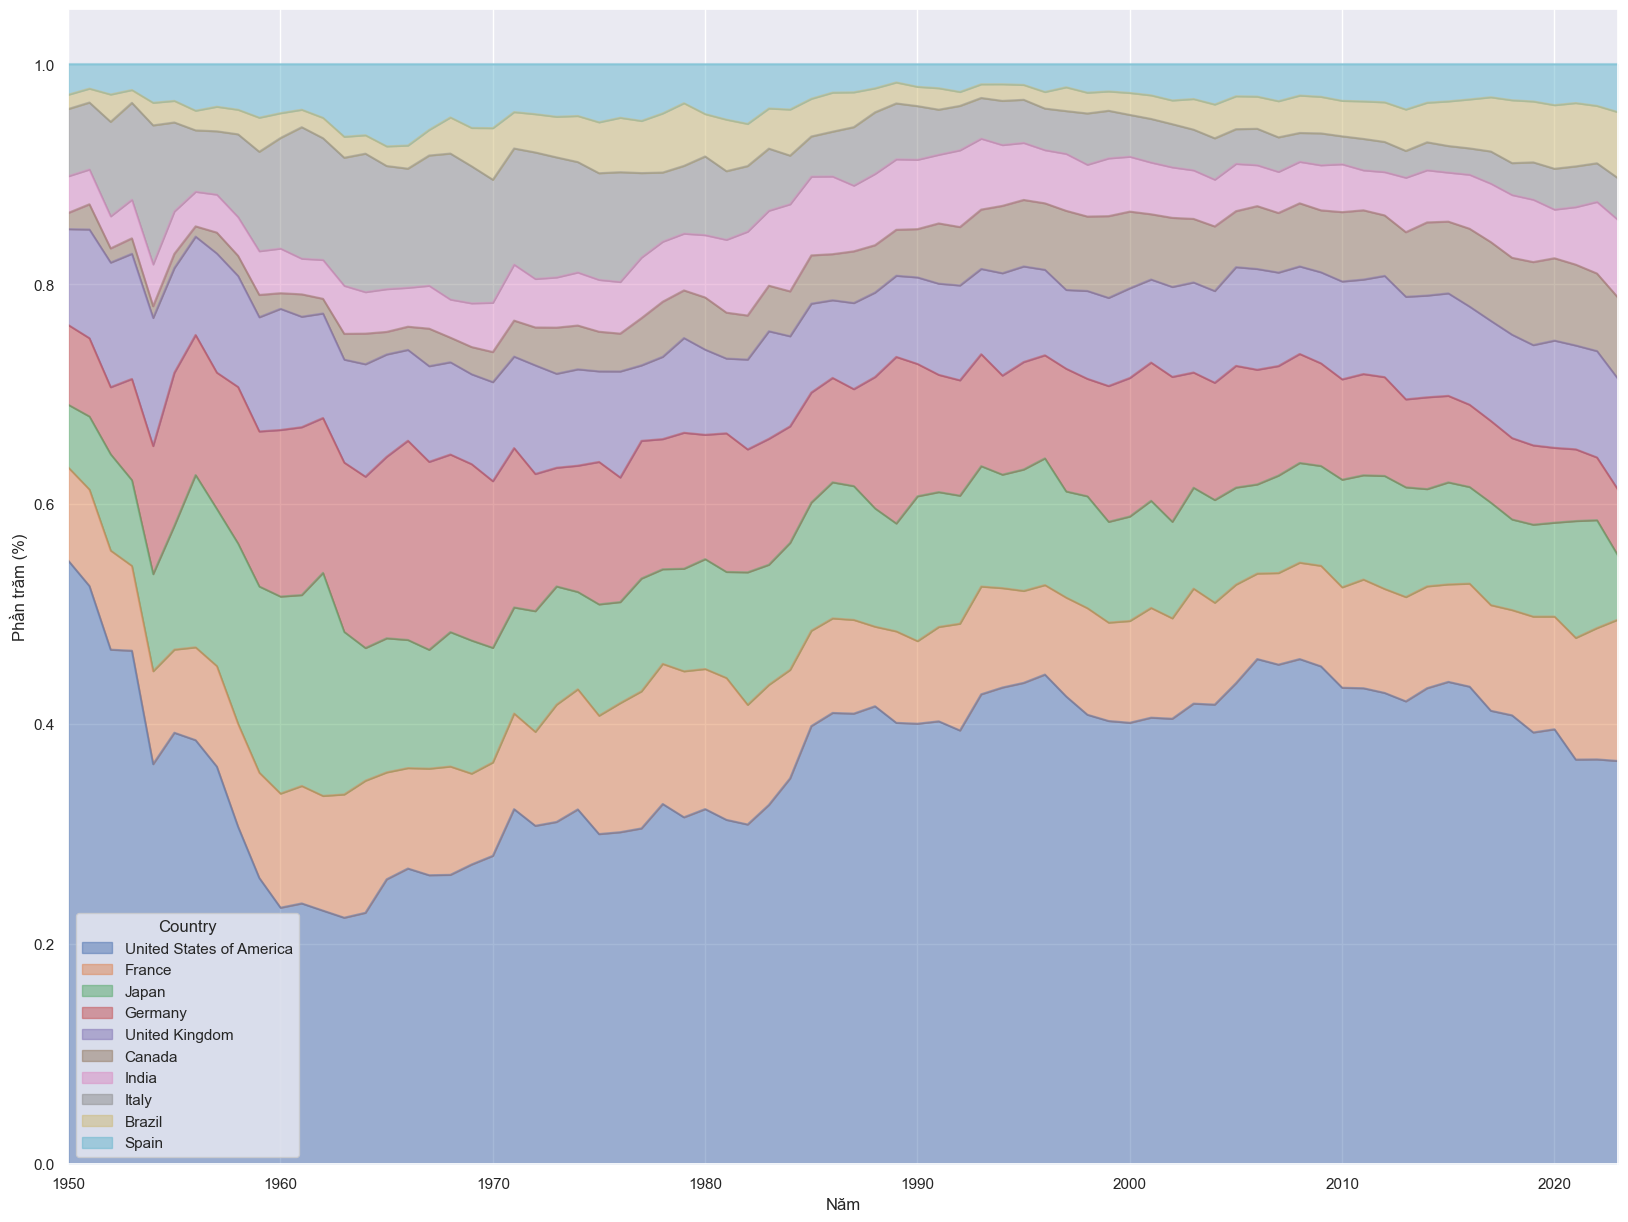

In [23]:
sns.set_theme()

ax = data_p.plot(kind='area', stacked=True, figsize=(20,15), alpha=0.5, sharex=True )

ax.set_ylabel('Phần trăm (%)')
ax.set_xlabel('Năm')
ax.margins(0, 0)

plt.show()


**Nhận xét**
- Mỹ (United States of America) là nước có số lượng phim trong TMDB cao hơn rất nhiều so với những nước khác qua các năm.
- Từ năm 1960, thị trường Châu Âu và Châu Á đã bắt đầu lấn chiếm thị trường Mỹ. Có vẻ gần đây, thị trương phim ở các châu lục này ngày càng phát triển mạnh và TMDB đã thấy tiềm năng ở các thị trường ở các châu lục này. Tuy nhiên khá khó hiểu rằng với dân số 1 tỷ dân của Trung Quốc lại không nằm trong top 10.


**Tiếp tục phân tích**
- *Để làm rõ sự phát triển về ngànhvphim của những nước top đầu, ta sẽ tiếp tục tiến hành phân tích tiến trình phát triển mỗi nước*

In [26]:
# huyển về dạng DataFrame để vẽ biểu đồ
TMDB_df_stacked = pd.DataFrame(TMDB_df.stack(0)).reset_index()
TMDB_df_stacked.columns = ['Year','Country','Count']
TMDB_df_stacked

,Year,Country,Count
0,1950.0,United States of America,674
1,1950.0,France,104
2,1950.0,Japan,70
3,1950.0,Germany,89
4,1950.0,United Kingdom,107
...,...,...,...
735,2023.0,Canada,1067
736,2023.0,India,1020
737,2023.0,Italy,548
738,2023.0,Brazil,868


C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


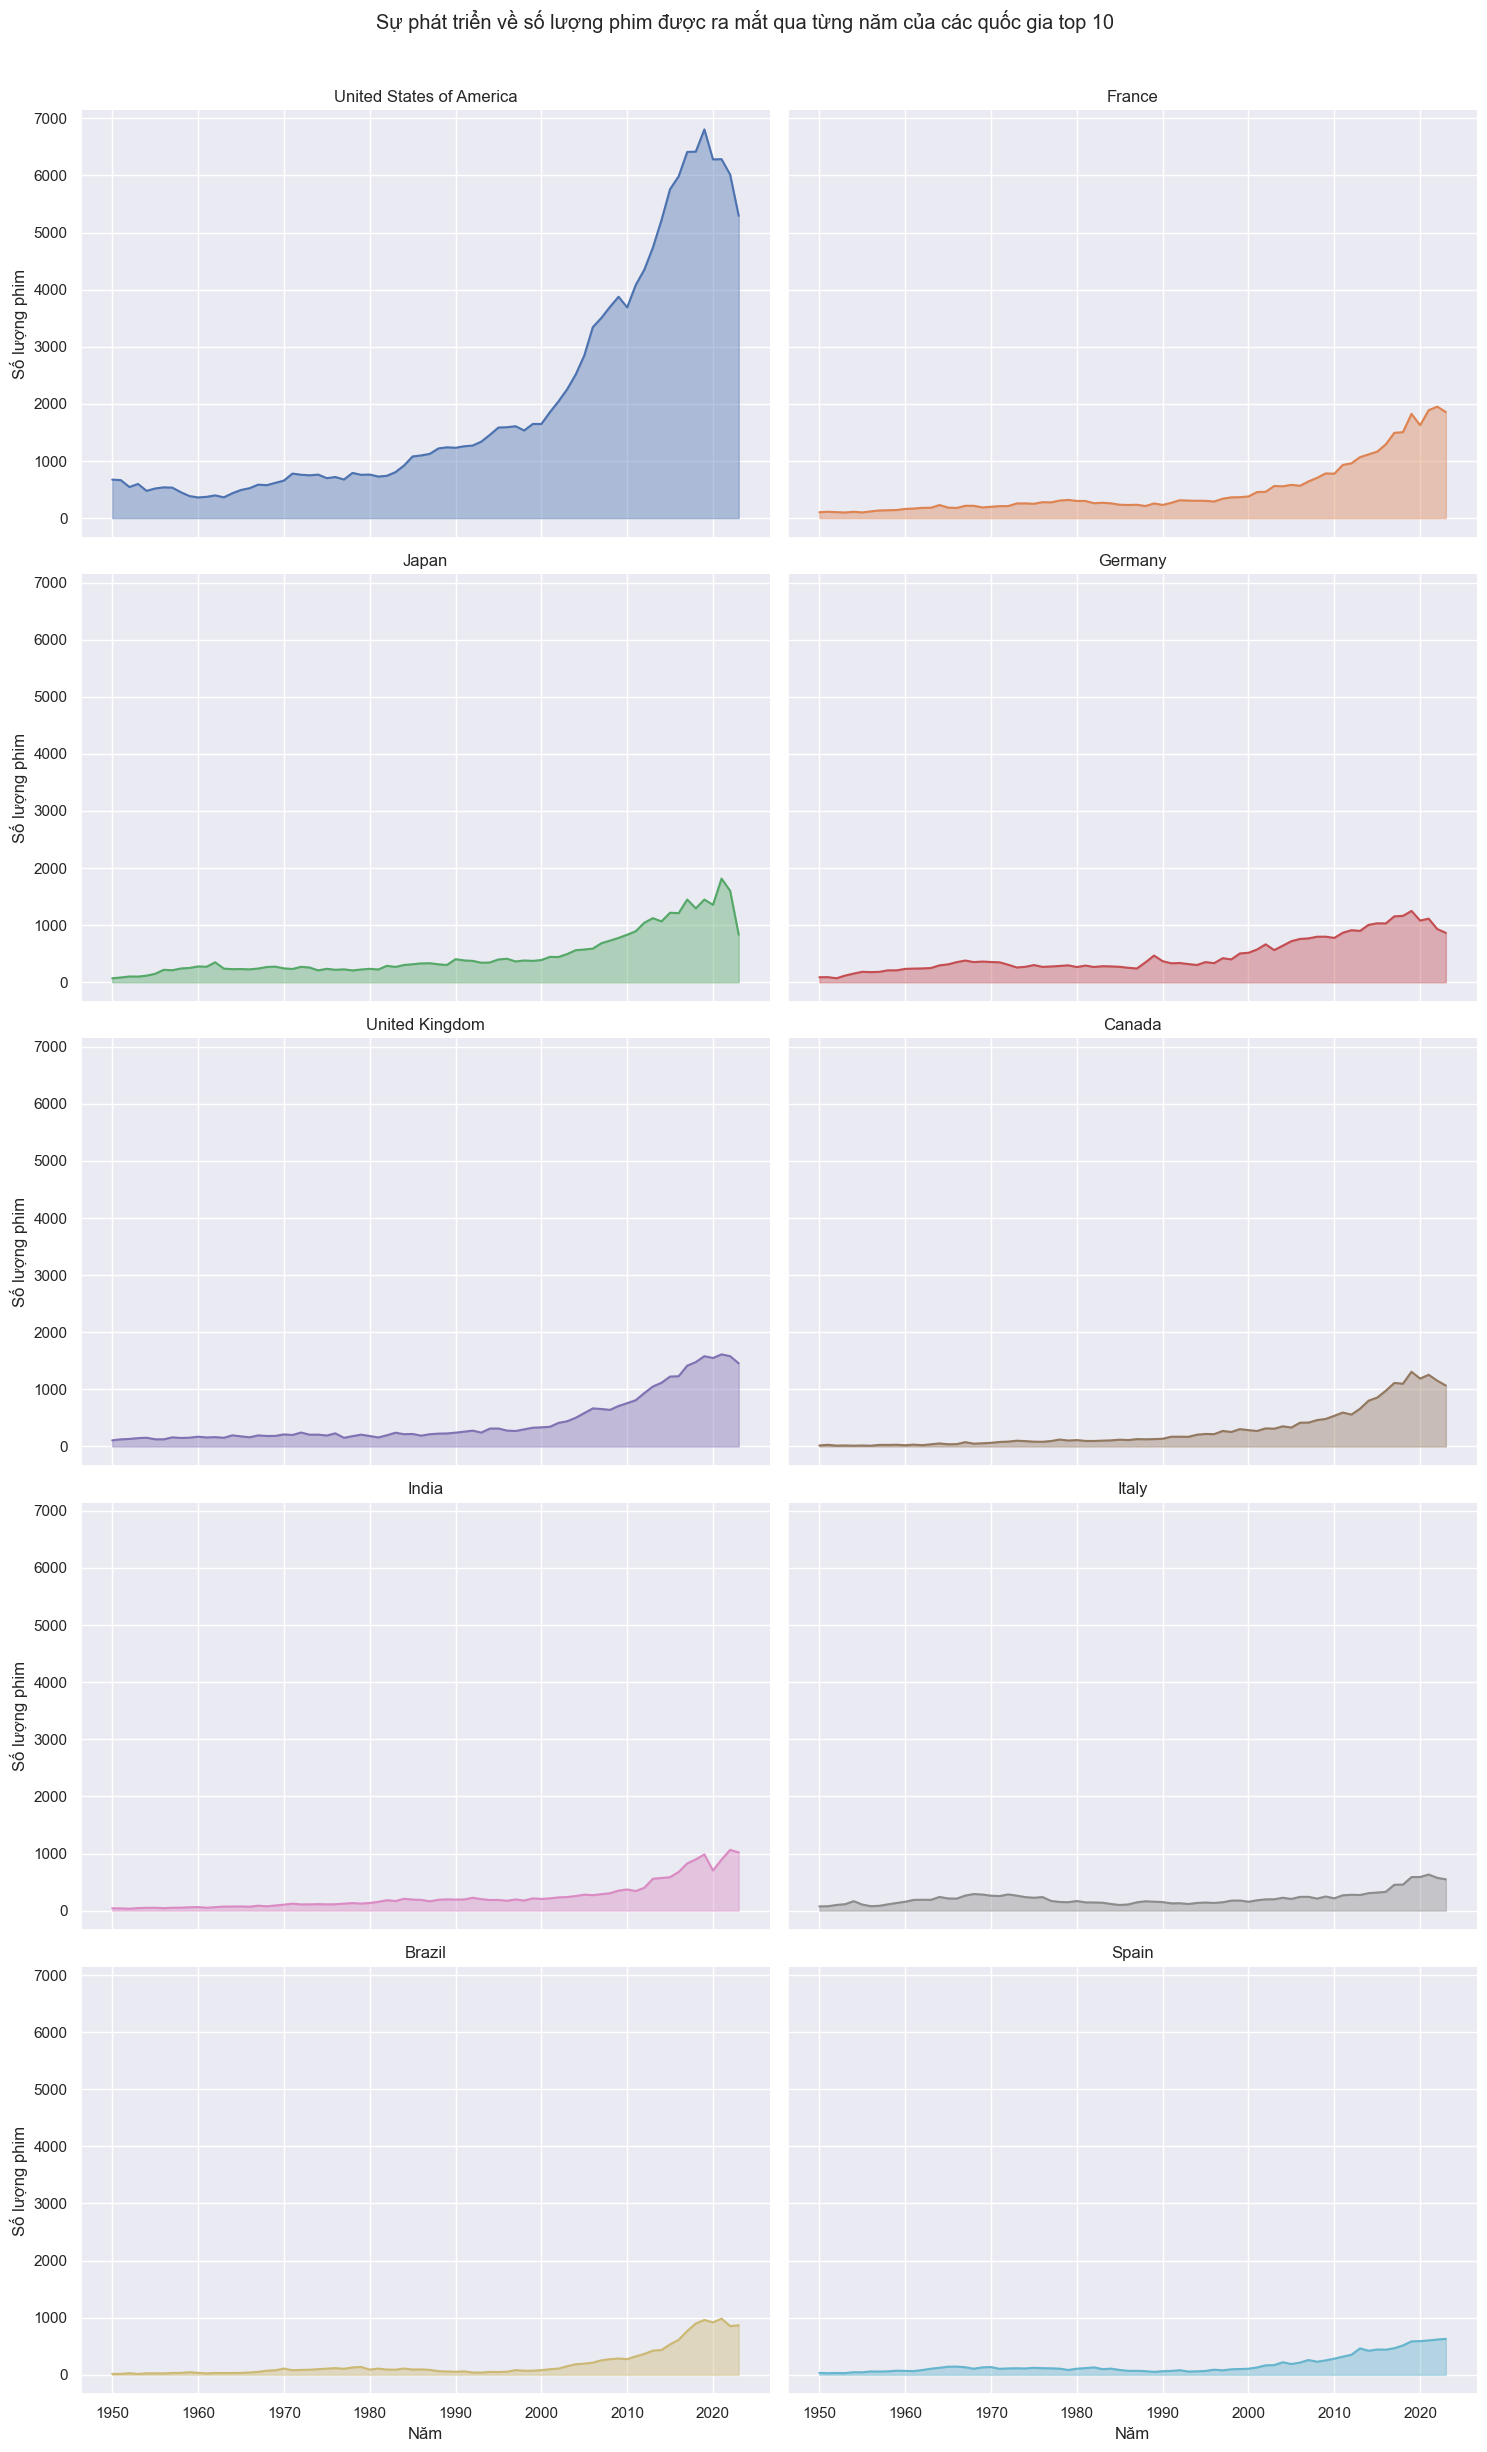

In [28]:
# Khởi tạo grid
g = sns.FacetGrid(TMDB_df_stacked, col='Country', hue='Country', 
                  col_wrap=2, height=5, aspect=1.5)

g = g.map(plt.plot, 'Year', 'Count')

# Tô màu các biểu đồ
g = g.map(plt.fill_between, 'Year', 'Count', alpha=0.4)
 
g = g.set_titles("{col_name}")
g = g.set_ylabels("Số lượng phim")
g = g.set_xlabels("Năm")

plt.subplots_adjust(top=0.94)
g = g.fig.suptitle('Sự phát triển về số lượng phim được ra mắt qua từng năm của các quốc gia top 10')

# Vẽ grid 
plt.show()


**Nhận Xét:**
- Các nước  đều có xu hướng tăng số lượng phim được ra mắt trong TMDB.
- Những năm dính Covid (2020-2021) là năm khiến nhiều nước lớn giảm sản xuất phim.


**Kiểm tra tình hình Việt Nam:**
- Việt Nam trong thời gian qua thì mảng phim hoạt động khá nhộn nhịp,do đó mục tiêu phần này là muốn xem xem tình hình phát triển của Việt Nam, liệu trong tương lai, Việt Nam có thể phát triển mạnh ở lĩnh vực phim ảnh hay không.

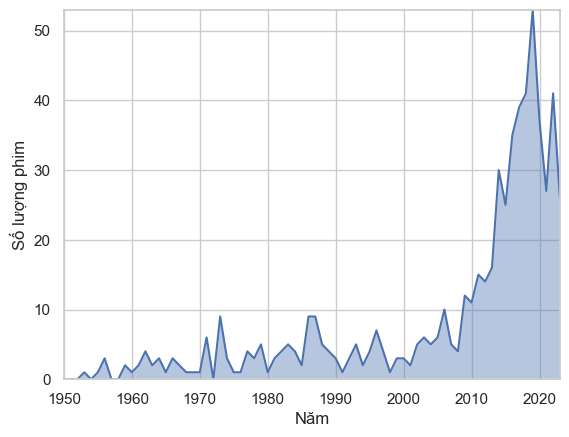

In [29]:
# Kiểm tra tình hình phát triển qua các năm
vietnam_df = TMDB_df_all.loc[:,['Vietnam']]

sns.set_theme(style="whitegrid")

ax = sns.lineplot(data=vietnam_df, x='year_release', y='Vietnam', legend=True)

plt.fill_between(x=vietnam_df.index, y1=vietnam_df.Vietnam.values, alpha=0.4)

ax.set(xlabel='Năm', ylabel='Số lượng phim')
ax.margins(0, 0)

plt.show()


In [30]:
# Các phim được thêm vào TMDB
df1.loc[df1.loc[:, 'production_countries'].apply(lambda x: 'Vietnam' in x)]\
   .sort_values(by='release_date')


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,year_release
520919,1046132,Two Worlds,0.0,0,Released,1953-01-01,0,61,False,NaN,...,Hai thế giới,"One of Vietnam’s first sound films, Two Worlds...",0.600,/3FllkkXm1L610Wm35lqifbx4GK3.jpg,NaN,Drama,NaN,"[France, Vietnam]",Vietnamese,1953.0
603615,1168004,Vietnam,0.0,0,Released,1955-05-01,0,64,False,NaN,...,Вьетнам,Story of the First Indochina War (1946-1954) i...,0.600,/2KxcKFiq9s7CLcWc8WNkboIG7oQ.jpg,NaN,Documentary,Russian Central Studio of Documentary Films,"[Soviet Union, Vietnam]",Russian,1955.0
667414,390632,We Want to Live,0.0,0,Released,1956-01-01,0,95,False,NaN,...,Chúng Tôi Muốn Sống,A realistic depiction of the bloody land refor...,0.655,NaN,NaN,"War, Drama",Tan Viet Dien Anh,[Vietnam],Vietnamese,1956.0
412985,949708,Saigon,0.0,0,Released,1956-04-18,0,0,False,NaN,...,Saigon,NaN,0.600,/kIEYUodtdugD7cH14SPfwYlblbu.jpg,NaN,Drama,Lebran,"[Philippines, Vietnam]",Tagalog,1956.0
601408,980596,Krus na Kawayan,0.0,0,Released,1956-12-05,0,95,False,NaN,...,Krus na Kawayan,Based on a true story about a valiant Vietname...,1.135,/kXeARNTqjTpzxOTWky09GfDoZWj.jpg,NaN,"Action, Drama","Vietnam Film, Manuel Conde Productions","[Philippines, Vietnam]","Tagalog, Vietnamese",1956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577174,1099580,The Last Wife,0.0,0,Post Production,2023-11-03,0,0,False,/55jXWq2Z3g1L0fTRHLJ36UPspmm.jpg,...,Người Vợ Cuối Cùng,"Inspired by the novel Ho Oan Han by Hong Thai,...",1.114,/dRgYeBp48TwCU84d6BR7A3VwfUi.jpg,NaN,"Drama, Romance","November Films, Lotte Entertainment (Vietnam),...",[Vietnam],Vietnamese,2023.0
422764,1118343,Black Rose,0.0,0,Released,2023-11-24,0,115,False,/u7vBLDg1OErWVEE4ij4EhqdYzvE.jpg,...,Appropriation,The story revolves around a babysitter named '...,0.916,/dFINeS3vgQoE3qZWvm82NdCmiCx.jpg,NaN,Thriller,NaN,[Vietnam],Vietnamese,2023.0
556404,1074087,Người Mặt Trời,0.0,0,Post Production,2023-12-08,0,0,False,NaN,...,Người Mặt Trời,Director Timothy Linh Bui said that the idea o...,0.689,/56KiS2dZg05il4NmKeR7YKWzEUx.jpg,NaN,Horror,NaN,[Vietnam],Vietnamese,2023.0
352065,1202618,Kẻ Ăn Hồn,0.0,0,Post Production,2023-12-08,0,0,False,/ogzF28LdMeJVKuX9SJKP2nwTnPq.jpg,...,Kẻ Ăn Hồn,NaN,0.000,/xihlZEVs6FqgVGR1ZvVN2FFXC4v.jpg,NaN,Horror,ProductionQ,[Vietnam],Vietnamese,2023.0


**Nhận xét**
- Vậy biểu đồ tăng trưởng Việt Nam tương tự như phần đông của thế giới khi phim được thêm vào năm từ năm 2000 là nhiều, có thể những năm này, TMDB đánh vào thị trường Việt Nam.
- Số lượng phim Việt Nam ra môi trường ngoài nước là rất ít so với các nước khác, tuy nhiên việc nằm trong danh sách số ít nước có phim  ở TMDB cũng cho thấy khả năng của người Việt như thế nào, có thể trong tương lai sẽ có nhiều nội dung ấn tượng để đưa Việt Nam phát triển mạnh hơn. Thị trường Việt Nam cũng được xem là thị trường tiềm năng.

### **Câu hỏi 4**: ghi nội dung ở đây<a name="cauhoi_4"></a>

**Ý nghĩa:**

### **Câu hỏi 4**: 5 công ty có doanh thu lớn nhất tập trung sản xuất các thể loại nào? <a name="cauhoi_3"></a>

**Ý nghĩa:**

In [14]:
companies_df = df[df['revenue'] > 0 ]

companies_df.loc[:,'production_companies'] = df['production_companies'].apply(lambda x: re.split(', |,', str(x)))
companies_df.loc[:,'production_companies'] = companies_df['production_companies'].apply(lambda x: [] if str(x) == "['nan']" else x)

companies_df.loc[:,'genres'] = df['genres'].apply(lambda x: re.split(', |,', str(x)))
companies_df.loc[:,'genres'] = companies_df['genres'].apply(lambda x: [] if str(x) == "['nan']" else x)

new_df = pd.DataFrame({
    'production_company': companies_df['production_companies'].explode().reset_index(drop=True),
    'revenue': companies_df['revenue'].explode().reset_index(drop=True),
    'genre': companies_df['genres'].explode().reset_index(drop=True)
})

top_countries = new_df.groupby('production_company')['revenue'].sum().reset_index()

top_countries = top_countries.sort_values(by='revenue', ascending=False).head(6)

top_countries_genres = new_df[new_df['production_company'].isin(top_countries['production_company'])]

<Figure size 1200x800 with 0 Axes>

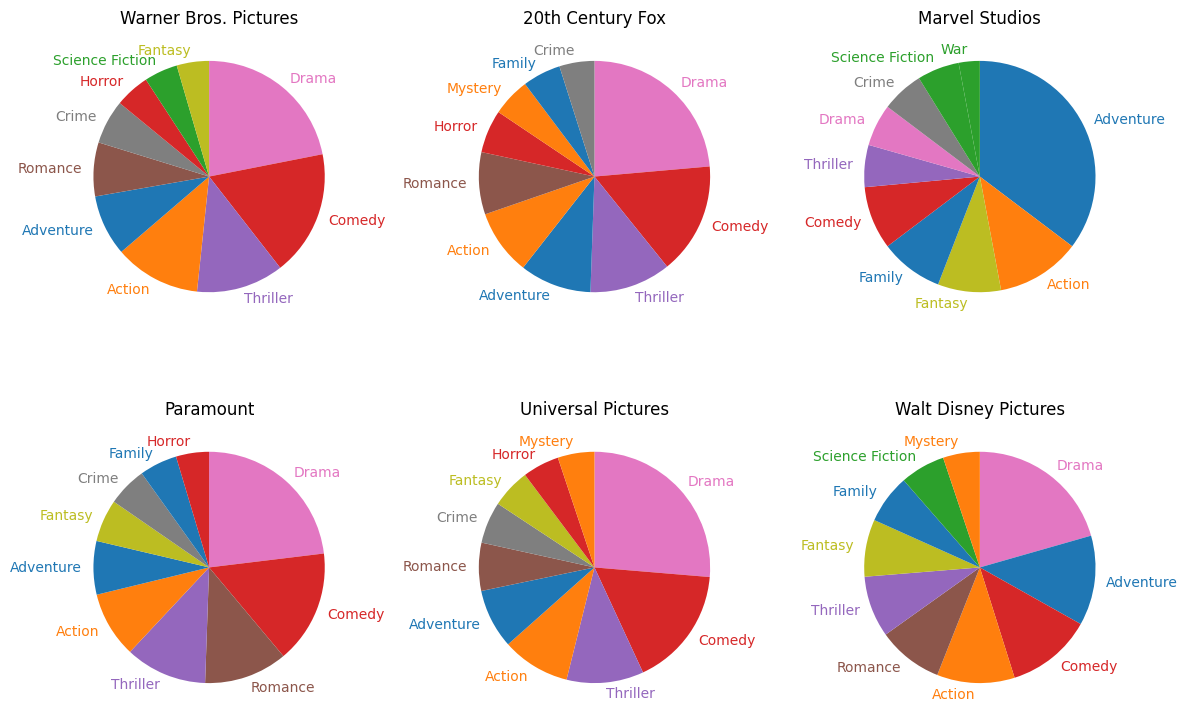

In [15]:
plt.figure(figsize=(12, 8))

all_genres = top_countries_genres['genre'].unique()
num_companies = len(top_countries_genres['production_company'].unique())

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

genre_palette = sns.color_palette('tab10', n_colors=len(all_genres), desat=1)
genre_color_mapping = dict(zip(all_genres, genre_palette))

for i, company in enumerate(top_countries_genres['production_company'].unique()):
    company_data = top_countries_genres[top_countries_genres['production_company'] == company]
    
    genre_counts = company_data['genre'].value_counts()
    genre_counts = genre_counts.reindex(all_genres, fill_value=0)
    genre_counts = genre_counts.sort_values(ascending=False)
    
    top_10_genres = genre_counts.head(10)
    
    colors = [genre_color_mapping.get(genre, 'gray') for genre in top_10_genres.index]
    wedges, texts, autotexts = axes[i].pie(top_10_genres, labels=None, autopct='', startangle=90, counterclock=False, colors=colors)
    
    for text, autotext, label, color in zip(texts, autotexts, top_10_genres.index, colors):
        text.set_text(label)
        text.set_color(color)
    
    axes[i].set_title(f'{company}')

plt.tight_layout()
plt.show()


### **Câu hỏi 5**: ghi nội dung ở đây<a name="cauhoi_5"></a>

**Ý nghĩa:**

# **Phase 5**: Reflection

## 5.0 Team members

**Văn Bá Bảo Huy**
- Khó khăn:
- Điều đã học được:

**Nguyễn Thị Gái**
- Khó khăn: 
    - Tìm dữ liệu có thể đáp ứng được việc trả lời các câu hỏi có ý nghĩa.
- Điều đã học được: 
    - Học được quy trình phân tích 1 bộ dữ liệu, trong quá trình làm đã tham khảo được nhiều bài phân tích dữ liệu với nhiều chủ đề.
    - Vận dụng pandas, matplotlib, searbon,... để xử lý dữ liệu và trực quan hoá dữ liệu.
    - Biết được tầm quan trọng trong việc tiền xử lý, chọn dữ liệu để cho ra kết quả tốt hơn.

**Nguyễn Thị Thanh Hoa**
- Khó khăn:
  - Chọn câu hỏi có ý nghĩa cần trả lời từ bộ dữ liệu này.
  - Sử dụng github để làm việc nhóm.
- Điều đã học được:
  - Nắm vững hơn các thư viện như pandas cho biến đổi dataframe cho các thao tác với dữ liệu , matplotlib, seaborn cho vẽ biểu đồ trực quan.
  - Tìm kiếm bất thương trong dữ liệu.
  - Rèn luyện kĩ năng đưa ra từng bước để phân tích, giải quyết một câu hỏi
  - Học hỏi thêm thao tác tiền xử lý, khám phá dữ liệu và đặt câu hỏi từ các tài liệu tham khảo.
  - Sử dụng gihub thành thạo hơn (ở mức cơ bản).

## 5.1 Team

Nếu có nhiều thời gian hơn, nhóm sẽ ...